In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from ase.cluster.wulff import wulff_construction
from qstem import Multislice, CTF
from qstem.util import atoms_plot

This notebook demonstrates the basic functionality of QSTEM-ASE using a model of a nanoparticle.

## Model

Set up a model of a gold nanoparticle as a Wulff construction and rotate it into the [110] zone axis.

('Actual number of atoms:', 1925)


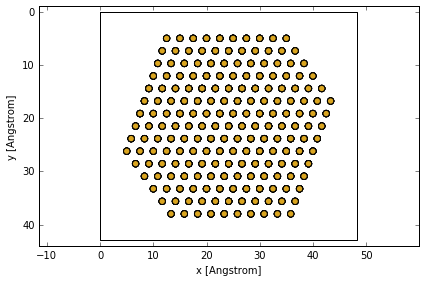

In [2]:
N = 2000 # Target number of atoms
surfaces = [(1, 0, 0), (1, 1, 0), (1, 1, 1)] # Surface directions
esurf = [1198, 1278, 979] # Corresponding surface energies mJ/m^2 (DFT values using the PBEsol functional)

atoms = wulff_construction('Au', surfaces, esurf, N, 'fcc', rounding='closest', latticeconstant=4.078)

atoms.rotate('y',a=np.pi/4.)
atoms.rotate('z',a=np.arctan(np.sqrt(2.)))
atoms.center(vacuum=5)

atoms_plot(atoms,direction=2)

print('Actual number of atoms:',len(atoms))

## Multislice algorithm

The plane wave is propagted through the electrostatic potential using the multislice algorithm. A sampling of at most 0.1 Angstrom/pixel and a slice thickness of at most 1 Angstrom is recommended.

In [3]:
energy=300 # Beam energy keV
sampling=0.1 # Angstrom/pixel
slice_thickness=1 # Angstrom
wave=Multislice(atoms,energy=energy,sampling=sampling,slice_thickness=slice_thickness).run()

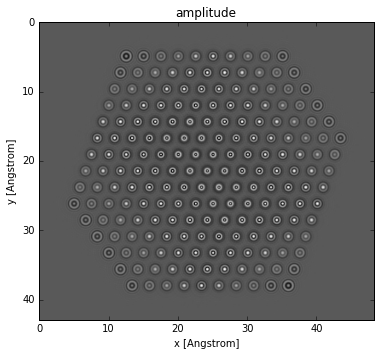

In [8]:
wave.view(method='amplitude')

The multislice algorithm returns a wave object. This is essentially just wrapper of a complex array with some additional properties such as energy. The complex array can be accessed as the property 'array'.

In [19]:
wave.array

array([[ 0.99883705 -1.35422428e-03j,  1.00051200 +6.34395925e-04j,
         1.00232100 +1.45097135e-03j, ...,  1.00180054 -9.50901536e-04j,
         1.00231111 +1.45729084e-03j,  1.00050795 +6.37436344e-04j],
       [ 0.99941093 -1.04286952e-03j,  1.00057840 +1.75105338e-03j,
         1.00084412 +1.41599856e-04j, ...,  0.99823880 +2.56047701e-03j,
         0.99848562 +8.98433907e-04j,  0.99911994 -1.29623816e-03j],
       [ 1.00083625 +1.12910193e-05j,  0.99951184 +7.40006682e-04j,
         0.99799180 +4.47359576e-04j, ...,  0.99832368 -8.65286973e-04j,
         0.99932331 -1.86873751e-03j,  1.00090492 -4.22050944e-04j],
       ..., 
       [ 1.00026774 +2.00163806e-04j,  1.00104749 +3.16583295e-03j,
         1.00198162 -5.90395590e-04j, ...,  1.00174928 +1.38023787e-03j,
         1.00086653 +5.76012128e-04j,  1.00001788 -1.89086481e-03j],
       [ 1.00083542 +1.33531485e-05j,  1.00091183 -4.24329657e-04j,
         0.99933410 -1.87447632e-03j, ...,  0.99745446 -5.64369606e-04j,
      

## Contrast Transfer Function
The wavefunction is propagated to the imageplane using the contrast transfer function (CTF). In this example we simulate an aberration corrected microscope with a spherical aberration (Cs) of 5 microns. Partial spatial and temporal coherence is included by applying an envelope to the wavefunction (quasi-coherent approximation). The envelope is controlled by the focal spread and convergence angle.

The focal spread is related to energy spread and lens instability as
$$\Delta =  C_c \sqrt{\left(\frac{\Delta E}{E}\right)^2+2\left(\frac{\Delta I}{I}\right)^2}$$
where $C_c$ is the chromatic aberration, $E$, $\Delta E$ is the energy and standard deviation of the energy spread and $I$, $\Delta I$ is the lens current and standard deviation of the lens current instability.

In [11]:
ctf=CTF(defocus=100,Cs=5*10**4,focal_spread=30)
img_wave=wave.apply_ctf(ctf) # returns a new wave object

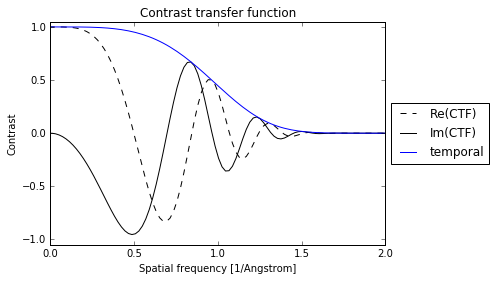

In [10]:
ctf.radial_plot()

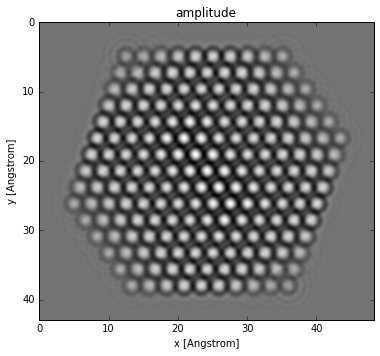

In [12]:
img_wave.view(method='amplitude')

## Detection

The detected image is simply the absolute square of the wavefunction at the image plane. Detector resolutions are typically worse than what is required by the multislice algorithm, hence the image needs to be downsampled to the correct resolution. 

Optionally, shot noise can be is simulated by specifying a finite electron dose. The mean of the Poisson distribution is given by

$$ \bar{N} = D\delta^2 I $$

where $D$ is the dose in electrons per Angstrom, $\delta^2$ is the pixel area and $I$ is absolute square of the wavefunction. The simulation does not include other sources of noise e.g. thermal noise.

In [19]:
resample=.18 # Angstrom/pixel
dose=5*10**3 #electrons/Angstrom^2
img=img_wave.detect(dose=dose,resample=resample) # returns a numpy array

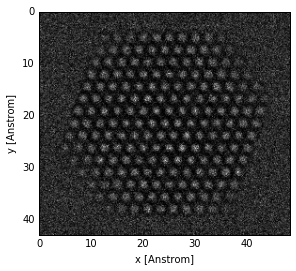

In [15]:
plt.imshow(img.T,extent=img_wave.get_extent(),cmap='gray')
plt.xlabel('x [Anstrom]')
plt.ylabel('y [Anstrom]')
plt.show()

## Export image

Images may be exported using the Python Imaging Library (PIL)

In [21]:
from PIL import Image
from qstem.util import draw_scalebar

img=img.astype(np.float32)
img=((img-img.min())/(img.max()-img.min()))
pil_img = Image.fromarray(img.T)

pil_img=draw_scalebar(pil_img,20/10,resample/10,units='nm',bg_color=1,placement=pil_img.size,anchor='bottom right',margin=3)

pil_img.save('nanoparticle.tiff')